# Tarea 1 - Face Recognition

## Preparation

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
import matplotlib.patches as mpatches
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
import pandas as pd
import os
from PIL import Image

plt.rcParams["figure.figsize"] = [9,4]

We are only considering 28 persons (from B11 to B39 because person B14 do not exist).

Images have the following format : 168x192.

In [2]:
# full path until the directory Cropped Yale
main_path = "/u/a/2019/apoupeau/Documentos/recpatr/face-recognition/CroppedYale"
# main_path = "/home/osboxes/Documents/python/recpatr/face-recognition/CroppedYale"

# defining the persons we consider 
dict_B_considered = {11:0, 12:1, 13:2, 15:3, 16:4, 17:5, 18:6, 19:7, 20:8, 
                      21:9, 22:10, 23:11, 24:12, 25:13, 26:14, 
                      27:15, 28:16, 29:17, 30:18, 31:19, 32:20, 
                      33:21, 34:22, 35:23, 36:24, 37:25, 38:26, 39:27}

# max_illu_strength_coef_percent_train
max_ist_cpt = 15

In [3]:
def illuminationStrength(azimuth, elevation):
    """
        Returns:
            ist (int) : illumination strength = |azimuth|+|elevation|
    """
    return np.abs(azimuth) + np.abs(elevation)

In [4]:
def imgPathToArray(img_path):
    """
        Returns:
            img_1D_vec (array)
    """
    img = plt.imread(img_path, "pgm")
    rows, cols = img.shape # gives dimensions for Grey Scale array
    img_size = rows*cols
    img_1D_vec = img.reshape(img_size)
    return img_1D_vec

In [5]:
def getData(path, max_ist_cpt):
    """
        Arguments:
            mcpt (int) : |azimuth|+|elevation| <= max_illu_strength_coef_percent_train
    
        Returns:
            train_data (array) 
            train_label (array)
            test_data (array)
    """
    train_data, train_label, train_illu, test_data, test_label, test_illu  = list(), list(), list(), list(), list(), list()
    for yale_dirname in os.listdir(path):
        # keeping only the persons we want
        if int(yale_dirname[-2:]) in dict_B_considered.keys():
            cur_person_imgs_path = os.path.join(main_path, yale_dirname)
            for face_image in os.listdir(cur_person_imgs_path):
                # keeping only the images (no info or log files)
                if len(face_image) >= 13 and face_image[-13] == "A":
                    azimuth = int(face_image[-12:-8])
                    elevation = int(face_image[-7:-4])
                    cur_img_path = os.path.join(cur_person_imgs_path, face_image)
                    img_1D_vec = imgPathToArray(img_path=cur_img_path)
                    label_img = dict_B_considered[int(face_image[5:7])]
                    illu_img = np.array([azimuth, elevation])
                    # train element
                    if illuminationStrength(azimuth, elevation) <= max_ist_cpt:
                        train_data.append(img_1D_vec)
                        train_label.append(label_img)
                        train_illu.append(illu_img)
                    # test data
                    else:
                        test_data.append(img_1D_vec)
                        test_label.append(label_img)
                        test_illu.append(illu_img)
    return np.array(train_data, dtype=int), np.array(train_label, dtype=int), np.array(train_illu), np.array(test_data, dtype=int), np.array(test_label, dtype=int), np.array(test_illu)

In [6]:
train_data, train_label, train_illu, test_data, test_label, test_illu = getData(path=main_path, 
                                                                                max_ist_cpt=max_ist_cpt)

We miss three files B16_A-010_E00, B17_A-010_E00 and B18_A-010_E00 because those files are corrupted.

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix with n_neighbors=1'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix with n_neighbors=1')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, cm


## RAW classification

In this part we are going to use the k-nearest-neighbours algorithm to solve the classification problem and see how well it performs on raw data on this specific dataset.

In [10]:
# train the knn model
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(train_data, train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

Confusion matrix with n_neighbors=1


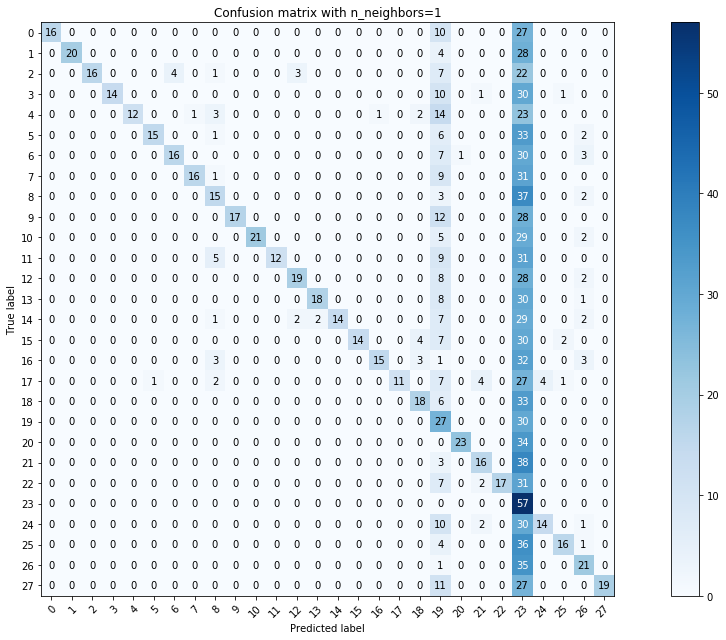

In [11]:
test_pred = knn_clf.predict(test_data)
ax, cm = plot_confusion_matrix(y_true=test_label,
                                    y_pred=test_pred,
                                    classes=np.array(list(dict_B_considered.values()), dtype=int))

In [12]:
def computeAccFromk(max_k_value):
    """
    """
    acc = np.zeros(max_k_value)
    k_values = np.linspace(1, max_k_value, max_k_value, dtype=int)
    for k in k_values:
        knn_clf = KNeighborsClassifier(n_neighbors=k)
        knn_clf.fit(train_data, train_label)
        test_pred = knn_clf.predict(test_data)
        accuracy = accuracy_score(y_true=test_label, y_pred=test_pred)
        acc[k-1] = accuracy
    return acc

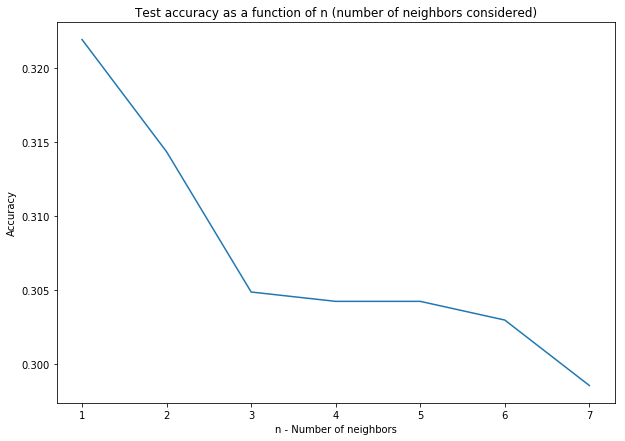

In [13]:
max_k_value = 7
k_values = np.linspace(1, max_k_value, max_k_value, dtype=int)
acc = computeAccFromk(max_k_value=max_k_value)

plt.figure(figsize=(10,7))
plt.plot(k_values, acc)
plt.title("Test accuracy as a function of n (number of neighbors considered)")
plt.xlabel("n - Number of neighbors")
plt.ylabel("Accuracy")
plt.show()

In [14]:
def orderFromIst(k, ist_sep, max_ist = 175):
    """
        ist always <= 175
    """
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(train_data, train_label)
    test_pred = knn_clf.predict(test_data)
    test_ist = np.array([illuminationStrength(illu[0], illu[1]) for illu in test_illu])
   
    order_from_ist = list()
    for i in range(0, max_ist, ist_sep):
        order_from_ist.append(np.array([[test_label[idx], test_pred[idx]] for idx, ist in enumerate(test_ist) if i <= ist and ist <= i+ist_sep]))
    
    return np.array(order_from_ist)

In [15]:
order_from_ist = orderFromIst(k=1, ist_sep=20)

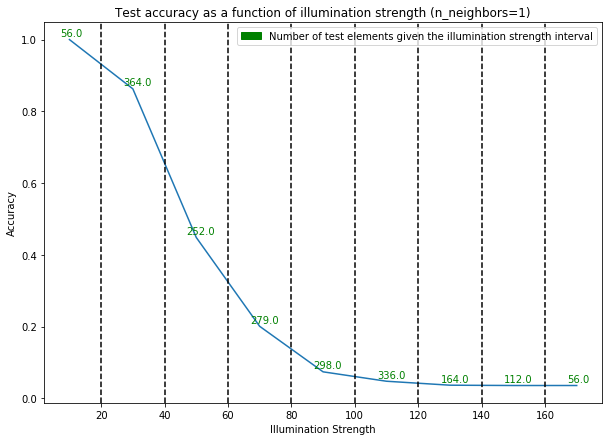

In [16]:
list_acc_ist = list()
for element in order_from_ist:
    acc = accuracy_score(y_true=element[:, 0], y_pred=element[:, 1])
    list_acc_ist.append([acc, int(element.shape[0])])
list_acc_ist = np.array(list_acc_ist)

z = np.linspace(0, 160, 9)
y = list_acc_ist[:, 0]
n = list_acc_ist[:, 1]

fig, ax = plt.subplots(figsize=(10,7))
plt.xticks(np.arange(0, 200, step=20))
ax.plot(z+10, y)

ist_values = np.linspace(0, 180, 10)
for ist_bound in ist_values[1:-1]:
    plt.axvline(x=ist_bound, linestyle='--', color='black')

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i]+7, y[i]+0.01), color='green')

    
red_patch = mpatches.Patch(color='green', label='Number of test elements given the illumination strength interval')
plt.legend(handles=[red_patch])
plt.xlabel("Illumination Strength")
plt.ylabel("Accuracy")
plt.title("Test accuracy as a function of illumination strength (n_neighbors=1)")
plt.show()

## PCA before classification

### Introduction

In this part we apply PCA to diminish the dimension of the input data before classifying.
Here is a function that reshape the images in order to display it.
It will be useful for the rest of the tasks.

In [7]:
def displayFace(vect, shape):
    """ Display the face from an input vector of shape = 192x168"""
    vect_reshape_for_img = vect.reshape(shape)
    plt.imshow(vect_reshape_for_img, cmap='gray', vmin=0, vmax=255)
    plt.show()

Here we define two function to get data and to reshape it as we wish.

In [8]:
def imgPathToArray2(img_path, output_shape):
    """
         Returns:
            img_1D_vec (array)
    """
    reversed_ouput_shape = (output_shape[1], output_shape[0])
    img = Image.open(img_path)
    reshaped_img = img.resize(reversed_ouput_shape, Image.ANTIALIAS)
    reshaped_img = np.asarray(reshaped_img)
    rows, cols = reshaped_img.shape # gives dimensions for Grey Scale array
    img_size = rows*cols
    img_1D_vec = reshaped_img.reshape(img_size)
    return img_1D_vec

In [9]:
def getData2(path, max_ist_cpt, output_shape):
    """
        Arguments:
            mcpt (int) : |azimuth|+|elevation| <= max_illu_strength_coef_percent_train
    
        Returns:
            train_data (array) 
            train_label (array)
            test_data (array)
    """
    train_data, train_label, train_illu, test_data, test_label, test_illu  = list(), list(), list(), list(), list(), list()
    for yale_dirname in os.listdir(path):
        # keeping only the persons we want
        if int(yale_dirname[-2:]) in dict_B_considered.keys():
            cur_person_imgs_path = os.path.join(main_path, yale_dirname)
            for face_image in os.listdir(cur_person_imgs_path):
                # keeping only the images (no info or log files)
                if len(face_image) >= 13 and face_image[-13] == "A":
                    azimuth = int(face_image[-12:-8])
                    elevation = int(face_image[-7:-4])
                    cur_img_path = os.path.join(cur_person_imgs_path, face_image)
                    img_1D_vec = imgPathToArray2(img_path=cur_img_path, output_shape=output_shape)
                    label_img = dict_B_considered[int(face_image[5:7])]
                    illu_img = np.array([azimuth, elevation])
                    # train element
                    if illuminationStrength(azimuth, elevation) <= max_ist_cpt:
                        train_data.append(img_1D_vec)
                        train_label.append(label_img)
                        train_illu.append(illu_img)
                    # test data
                    else:
                        test_data.append(img_1D_vec)
                        test_label.append(label_img)
                        test_illu.append(illu_img)
    return np.array(train_data, dtype=int), np.array(train_label, dtype=int), np.array(train_illu), np.array(test_data, dtype=int), np.array(test_label, dtype=int), np.array(test_illu)

In [10]:
train_data2, train_label, train_illu, test_data2, test_label, test_illu = getData2(path=main_path, 
                                                                                max_ist_cpt=max_ist_cpt,
                                                                                 output_shape=(96,84))

(193, 8064)


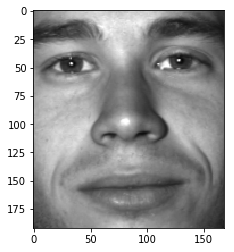

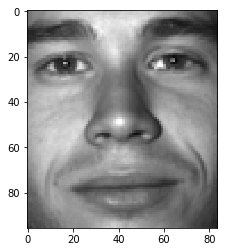

In [11]:
print(train_data2.shape)
displayFace(vect=train_data[0, :], shape=(192,168))
displayFace(vect=train_data2[0, :], shape=(96, 84))

### 1) My PCA

In [13]:
def reorderImg(img_vec, end=(0,255)):
    minimum, maximum = np.min(img_vec), np.max(img_vec)
    reordered_img = np.array([(x-minimum)/(maximum-minimum)*end[1] + end[0] for x in img_vec])
    return reordered_img

In [14]:
def reorderImgMean(img_vec, mean_img):
    minimum, maximum = np.min(img_vec), np.max(img_vec)
    reordered_img = np.array([(x-minimum)/(maximum-minimum)*mean_img[i] for i,x in enumerate(img_vec)])
    return reordered_img

In [99]:
def myPCA(data, n_components):
    """ 
        Arguments: 
            data (array) : shape (N_samples, n_features)
            n_components (int) : numbers of first principal components to keep
            
        Returns:
            best_n_eigenvectors (array) : has a shape (n_features, n_components)
            mean_img (array) : has a shape 
    """
    # mean image
    mean_img = np.mean(data, axis=0)
    
    # center the data for input svd
    input_svd = data - mean_img
    
    # Singular-value decomposition
    U, s, VT = np.linalg.svd(input_svd, full_matrices=False)
    
    # get the n_components highest eigenvalues indexes
    ordered_n_best_eigenvalues_idx = np.zeros(n_components)
    for i in range(0, n_components):
        index_max = np.argmax(s)
        ordered_n_best_eigenvalues_idx[i] = index_max
        s[index_max] = 0
    
    # get the best eigenvectors
    best_n_eigenvectors = list()
    for idx in ordered_n_best_eigenvalues_idx:
        best_n_eigenvectors.append(VT[int(idx), :])
    # here now best_n_eigenvectors has a shape of (img_size, n_components)
    best_n_eigenvectors = np.asarray(best_n_eigenvectors).T
    
    # display images eigenvectors representation
#     for vec in best_n_eigenvectors.T:
#         displayFace(reorderImg(vec), shape=(96,84))
    
    return best_n_eigenvectors, mean_img

In [100]:
eigen_vectors, mean_img = myPCA(train_data2, n_components=10)

### 2) Projection

In [104]:
def getProjection(I, train_data, k):
    """
        Compute projection of the image using the k first principal components
    """
    k_eigenvectors, mean_img = myPCA(data=train_data, n_components=k)
    return np.matmul(I, k_eigenvectors)

In [105]:
def getReProjection(I, train_data, k):
    """
        Compute Reprojection of the image using the k first principal components
    """
    k_eigenvectors, mean_img = myPCA(data=train_data, n_components=k)
    return np.matmul(np.matmul(I, k_eigenvectors), k_eigenvectors.T) + mean_img

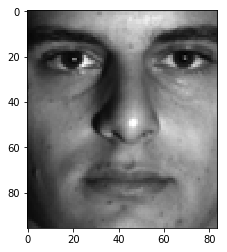

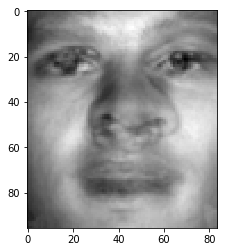

In [108]:
for _ in range(0, 1):
    idx = np.random.randint(0, 1500)
    displayFace(test_data2[idx, :], shape=(96,84))
    displayFace(reorderImg(getReProjection(test_data2[idx, :], train_data=train_data2, k=3)), shape=(96,84))

### 3) Classify after using PCA

In [23]:
def PCAopt(k):
    """
    """
    

In [29]:
def computeAccFromkPCA(k_values, n_neighbours):
    """
    """
    acc = np.zeros((len(n_neighbours), len(k_values)))
    for n in n_neighbours:
        for k in k_values:
            pca = PCA(n_components=k)
            reduced_train_data = pca.fit_transform(train_data)
            reduced_test_data = pca.transform(test_data)
            knn_clf = KNeighborsClassifier(n_neighbors=n)
            knn_clf.fit(reduced_train_data, train_label)
            test_pred = knn_clf.predict(reduced_test_data)
            accuracy = accuracy_score(y_true=test_label, y_pred=test_pred)
            acc[n-1, k-1] = accuracy
    return acc

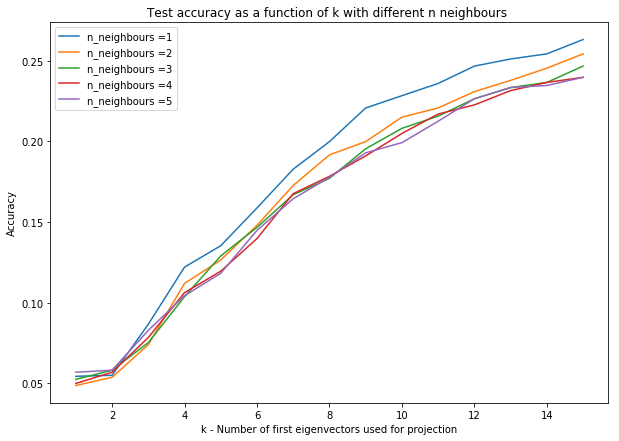

In [30]:
max_k_value = 15
k_values = np.linspace(1, max_k_value, max_k_value, dtype=int)
max_n_neighbours = 5
n_neighbours = np.linspace(1, max_n_neighbours, max_n_neighbours, dtype=int)
acc = computeAccFromkPCA(k_values = k_values,
                         n_neighbours = n_neighbours)

plt.figure(figsize=(10,7))
for i, acc_n in enumerate(acc):
    plt.plot(k_values, acc_n, label="n_neighbours ="+str(n_neighbours[i]))
plt.title("Test accuracy as a function of k with different n neighbours ")
plt.xlabel("k - Number of first eigenvectors used for projection")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [31]:
def orderFromIstPCA(k_values, ist_values, ist_sep, n_neighbors=1, ):
    """
        ist always <= 175
    """
    test_ist = np.array([illuminationStrength(illu[0], illu[1]) for illu in test_illu])
    
    acc = np.zeros((len(k_values), len(ist_values)-1))
    for k in k_values:
        for i, ist in enumerate(ist_values[:-1]):
            pca = PCA(n_components=k)
            reduced_train_data = pca.fit_transform(train_data)
            reduced_test_data = pca.transform(test_data)
            knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn_clf.fit(reduced_train_data, train_label)
            test_pred = knn_clf.predict(reduced_test_data)
            indexes = np.where((test_ist >= ist) & (test_ist <= ist+ist_sep))
            curr_acc = accuracy_score(y_true=test_label[indexes] , y_pred=test_pred[indexes])
            acc[k-1, i] = curr_acc
    return acc

In [32]:
max_k_value = 15
k_values = np.linspace(1, max_k_value, max_k_value, dtype=int)
ist_values = np.linspace(0, 180, 10)
print("ist_values =", ist_values)
acc_from_ist_pcak = orderFromIstPCA(k_values=k_values, ist_values=ist_values, ist_sep=20)

ist_values = [  0.  20.  40.  60.  80. 100. 120. 140. 160. 180.]


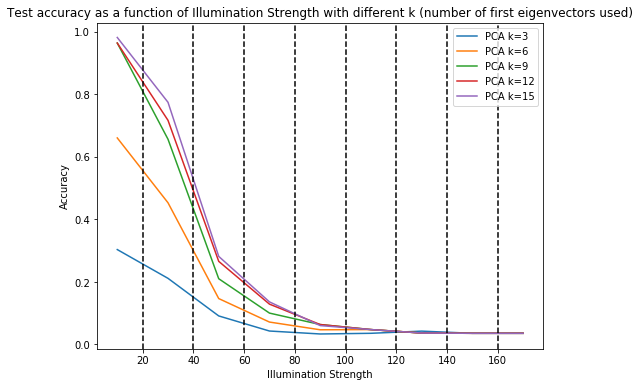

In [33]:
plt.figure(figsize=(8,6))
for i, element in enumerate(acc_from_ist_pcak):
    if (i+1) % 3 == 0:
        plt.plot(ist_values[:-1]+10, element, label="PCA k="+str(k_values[i]))
for ist_bound in ist_values[1:-1]:
    plt.axvline(x=ist_bound, linestyle='--', color='black')
plt.legend()
plt.xlabel("Illumination Strength")
plt.ylabel("Accuracy")
plt.title("Test accuracy as a function of Illumination Strength with different k (number of first eigenvectors used)")
plt.show()

### 4) Multilayer Perceptron

In [34]:
def classifierMLP(ist_values, ist_sep, k=25):
    """
    """
    test_ist = np.array([illuminationStrength(illu[0], illu[1]) for illu in test_illu])
    
    acc = np.zeros(len(ist_values)-1)
    for i, ist in enumerate(ist_values[:-1]):
        pca = PCA(n_components=25)
        reduced_train_data = pca.fit_transform(train_data)
        reduced_test_data = pca.transform(test_data)
        mlp_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(2000), max_iter=500)
        mlp_clf.fit(reduced_train_data, train_label)
        test_pred = mlp_clf.predict(reduced_test_data)
        indexes = np.where((test_ist >= ist) & (test_ist <= ist+ist_sep))
        curr_acc = accuracy_score(y_true=test_label[indexes] , y_pred=test_pred[indexes])
        acc[i] = curr_acc
    return acc

In [35]:
ist_values = np.linspace(0, 180, 10)
print("ist_values =", ist_values)
acc_from_ist_pcak_mlp = classifierMLP(ist_values=ist_values, ist_sep=20, k=25)
print("accuracy =", acc_from_ist_pcak_mlp)

ist_values = [  0.  20.  40.  60.  80. 100. 120. 140. 160. 180.]
accuracy = [0.94642857 0.76373626 0.28968254 0.15053763 0.06375839 0.08928571
 0.03658537 0.03571429 0.03571429]


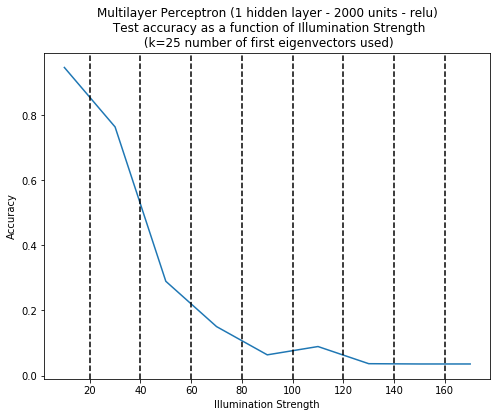

In [36]:
plt.figure(figsize=(8,6))
plt.plot(ist_values[:-1]+10, acc_from_ist_pcak_mlp)
for ist_bound in ist_values[1:-1]:
    plt.axvline(x=ist_bound, linestyle='--', color='black')
plt.xlabel("Illumination Strength")
plt.ylabel("Accuracy")
plt.title("Multilayer Perceptron (1 hidden layer - 2000 units - relu)\n Test accuracy as a function of Illumination Strength\n (k=25 number of first eigenvectors used)")
plt.show()